## DataFrame benchmarks with object vs. string[pyarrow] data

In [1]:
import dask
dask.utils.show_versions()

{
  "Python": "3.11.0",
  "Platform": "Darwin",
  "dask": "2023.3.2",
  "distributed": "2023.3.2",
  "numpy": "1.24.2",
  "pandas": "2.0.0rc1",
  "cloudpickle": "2.2.1",
  "fsspec": "2023.3.0",
  "bokeh": "2.4.3",
  "fastparquet": null,
  "pyarrow": "11.0.0",
  "zarr": null
}

In [2]:
import pandas as pd
import numpy as np
from dask.sizeof import sizeof
from dask.utils import format_bytes
from dask import delayed
from dask.distributed import PipInstall, PackageInstall
import dask.dataframe as dd
import random
import string
from distributed import wait
from distributed import Client
from distributed.diagnostics import MemorySampler
import coiled
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from dask.distributed import performance_report

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
cluster

2023-03-29 13:08:48,727 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/w6/twsr_k_17m3fbmpgvpnp_v700000gn/T/dask-worker-space/worker-e5bc5xoj', purging
2023-03-29 13:08:48,727 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/w6/twsr_k_17m3fbmpgvpnp_v700000gn/T/dask-worker-space/worker-3fql6uo0', purging


LocalCluster(dbc00292, 'tcp://127.0.0.1:56988', workers=4, threads=12, memory=64.00 GiB)

In [5]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56988,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:56999,Total threads: 3
Dashboard: http://127.0.0.1:57003/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:56991,


In [6]:
file_paths = [
    f"s3://nyc-tlc/trip data/yellow_tripdata_{year}*.parquet"
    for year in (2021, 2022)
]
file_paths

['s3://nyc-tlc/trip data/yellow_tripdata_2021*.parquet',
 's3://nyc-tlc/trip data/yellow_tripdata_2022*.parquet']

In [7]:
ddf = dd.read_parquet(
    file_paths,
    columns=["VendorID", "passenger_count", "trip_distance", "store_and_fwd_flag", "total_amount"],
)

In [8]:
wait(ddf);

## Memory usage of the object string column

In [9]:
from dask.utils import format_bytes

format_bytes(ddf.store_and_fwd_flag.memory_usage(deep=True).compute())

'3.72 GiB'

## Take a look at data types

In [10]:
ddf.dtypes

VendorID                int64
passenger_count       float64
trip_distance         float64
store_and_fwd_flag     object
total_amount          float64
dtype: object

In [12]:
ddf = ddf.persist()

In [11]:
ddf.npartitions

24

In [13]:
memory_usage_object = ddf.memory_usage_per_partition().compute().apply(format_bytes)
memory_usage_object

0      52.25 MiB
1      52.33 MiB
2      73.44 MiB
3      82.82 MiB
4      95.64 MiB
5     108.12 MiB
6     107.64 MiB
7     106.38 MiB
8     113.06 MiB
9     132.12 MiB
10    132.48 MiB
11    122.62 MiB
12     93.99 MiB
13    113.66 MiB
14    138.39 MiB
15    137.33 MiB
16    136.88 MiB
17    135.73 MiB
18    121.09 MiB
19    120.27 MiB
20    121.45 MiB
21    140.21 MiB
22    124.08 MiB
23    129.68 MiB
dtype: object

## Create memory samplers and store benchmarks with object strings

In [14]:
ms1 = MemorySampler()
ms2 = MemorySampler()
ms3 = MemorySampler()
ms4 = MemorySampler()
ms5 = MemorySampler()
ms6 = MemorySampler()

In [15]:
report_dir = "performance/local4workers"

In [16]:
import time

In [17]:
%timeit -r 5 -n 2 ddf.store_and_fwd_flag.unique().compute()

337 ms ± 75 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [18]:
# 1
with performance_report(filename=f"{report_dir}/1-object-unique.html"):
    with ms1.sample("object string", interval=0.01):
        for _ in range(10):
            ddf.store_and_fwd_flag.unique().compute()
            time.sleep(0.2)

In [21]:
%timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").total_amount.sum().compute()

814 ms ± 6.64 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [22]:
# 2
with performance_report(filename=f"{report_dir}/2-object-group-sum.html"):
    with ms2.sample("object string", interval=0.01):
        for _ in range(10):
            ddf.groupby("store_and_fwd_flag").total_amount.sum().compute()
            time.sleep(0.2)

In [24]:
%timeit -r 5 -n 2 ddf.groupby("store_and_fwd_flag").trip_distance.mean().compute()

1.36 s ± 294 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [25]:
# 3
with performance_report(filename=f"{report_dir}/3-object-group-mean.html"):
    with ms3.sample("object string", interval=0.01):
        for _ in range(10):
            ddf.groupby("store_and_fwd_flag").trip_distance.mean().compute()
            time.sleep(0.2)

In [26]:
%timeit -r 5 -n 2 ddf.store_and_fwd_flag.str.len().compute()

2.7 s ± 148 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [27]:
# 4
with performance_report(filename=f"{report_dir}/4-object-strlen.html"):
    with ms5.sample("object string", interval=0.01):
        for _ in range(10):
            ddf.store_and_fwd_flag.str.len().compute()
            time.sleep(0.2)

## Restart the client

In [28]:
client.restart()

2023-03-29 13:16:39,324 - distributed.nanny - WARNING - Restarting worker
2023-03-29 13:16:39,360 - distributed.nanny - WARNING - Restarting worker
2023-03-29 13:16:39,362 - distributed.nanny - WARNING - Restarting worker
2023-03-29 13:16:39,369 - distributed.nanny - WARNING - Restarting worker


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56988,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: 7 minutes ago,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:57200,Total threads: 3
Dashboard: http://127.0.0.1:57204/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:56991,


## Now store benchmarks with arrow strings, and plot the difference

In [36]:
with dask.config.set({"dataframe.convert_string": True}):
    ddf2 = dd.read_parquet(
        file_paths,
        columns=["VendorID", "passenger_count", "trip_distance", "store_and_fwd_flag", "total_amount"],
    )

In [30]:
wait(ddf2);

## Memory usage of the arrow string column

In [31]:
format_bytes(ddf2.store_and_fwd_flag.memory_usage(deep=True).compute())

'342.16 MiB'

In [37]:
ddf2 = ddf2.persist()

## Take a look at the dataframe dtypes

In [23]:
ddf2.npartitions

42

In [38]:
memory_usage_string = ddf2.memory_usage_per_partition().compute().apply(format_bytes)
memory_usage_string

0      48.40 MiB
1      48.47 MiB
2      68.04 MiB
3      76.75 MiB
4      88.64 MiB
5     100.23 MiB
6      99.78 MiB
7      98.61 MiB
8     104.80 MiB
9     122.50 MiB
10    122.84 MiB
11    113.71 MiB
12     87.17 MiB
13    105.39 MiB
14    128.33 MiB
15    127.34 MiB
16    126.92 MiB
17    125.85 MiB
18    112.29 MiB
19    111.53 MiB
20    112.61 MiB
21    130.00 MiB
22    115.05 MiB
23    120.24 MiB
dtype: object

In [34]:
memory_usage_object

0      52.25 MiB
1      52.33 MiB
2      73.44 MiB
3      82.82 MiB
4      95.64 MiB
5     108.12 MiB
6     107.64 MiB
7     106.38 MiB
8     113.06 MiB
9     132.12 MiB
10    132.48 MiB
11    122.62 MiB
12     93.99 MiB
13    113.66 MiB
14    138.39 MiB
15    137.33 MiB
16    136.88 MiB
17    135.73 MiB
18    121.09 MiB
19    120.27 MiB
20    121.45 MiB
21    140.21 MiB
22    124.08 MiB
23    129.68 MiB
dtype: object

In [39]:
ddf2.dtypes

VendorID                        int64
passenger_count               float64
trip_distance                 float64
store_and_fwd_flag    string[pyarrow]
total_amount                  float64
dtype: object

In [43]:
%timeit -r 5 -n 2 ddf2.store_and_fwd_flag.unique().compute()

The slowest run took 27.67 times longer than the fastest. This could mean that an intermediate result is being cached.
58.5 ms ± 32.5 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [44]:
# 1, ddf2
with performance_report(filename=f"{report_dir}/1-string-unique.html"):
    with ms1.sample("arrow string", interval=0.01):
        for _ in range(10):
            ddf2.store_and_fwd_flag.unique().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Unique'}, xlabel='time', ylabel='Cluster memory (GiB)'>

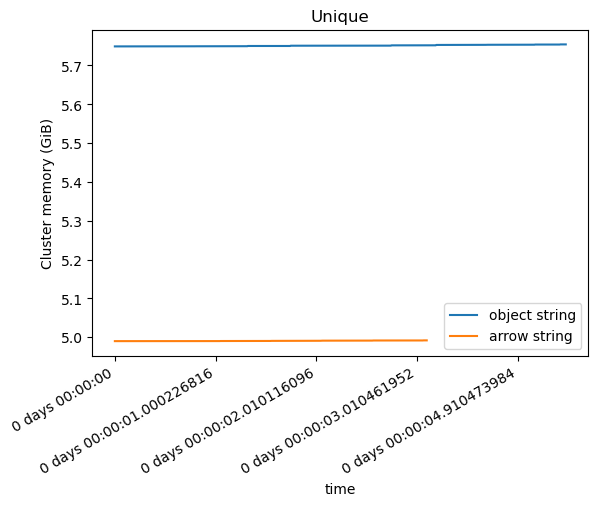

In [45]:
ms1.plot(align=True, title="Unique")

In [ ]:
%timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").total_amount.sum().compute()

In [46]:
# 2, ddf2
with performance_report(filename=f"{report_dir}/2-string-group-sum.html"):
    with ms2.sample("arrow string", interval=0.01):
        for _ in range(10):
            ddf2.groupby("store_and_fwd_flag").total_amount.sum().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Groupby/sum'}, xlabel='time', ylabel='Cluster memory (GiB)'>

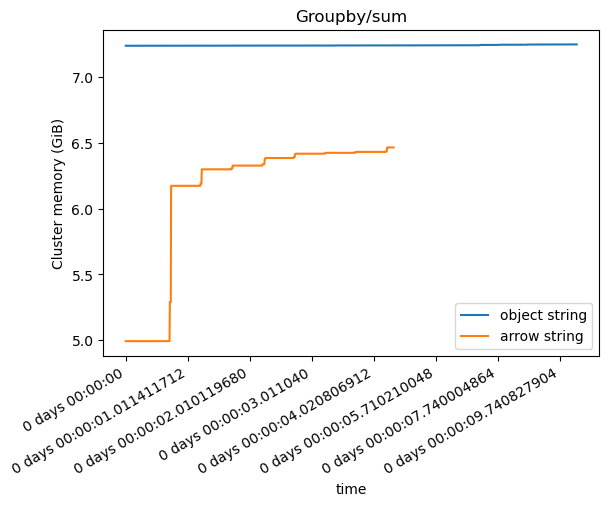

In [47]:
ms2.plot(align=True, title="Groupby/sum")

In [ ]:
%timeit -r 5 -n 2 ddf2.groupby("store_and_fwd_flag").trip_distance.mean().compute()

In [48]:
# 3, ddf2
with performance_report(filename=f"{report_dir}/3-string-group-mean.html"):
    with ms3.sample("arrow string", interval=0.01):
        for _ in range(10):
            ddf2.groupby("store_and_fwd_flag").trip_distance.mean().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Groupby/mean'}, xlabel='time', ylabel='Cluster memory (GiB)'>

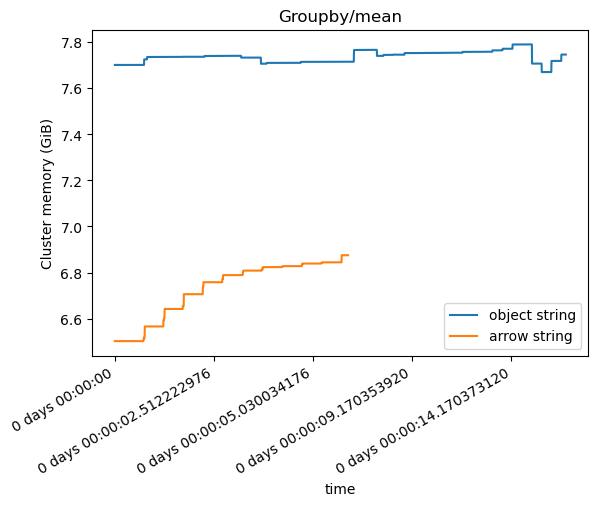

In [49]:
ms3.plot(align=True, title="Groupby/mean")

In [ ]:
%timeit -r 5 -n 2 ddf2.store_and_fwd_flag.str.len().compute()

In [50]:
# 4, ddf2
with performance_report(filename=f"{report_dir}/4-string-strlen.html"):
    with ms5.sample("arrow string", interval=0.01):
        for _ in range(10):
            ddf2.store_and_fwd_flag.str.len().compute()
            time.sleep(0.2)

<Axes: title={'center': 'String length'}, xlabel='time', ylabel='Cluster memory (GiB)'>

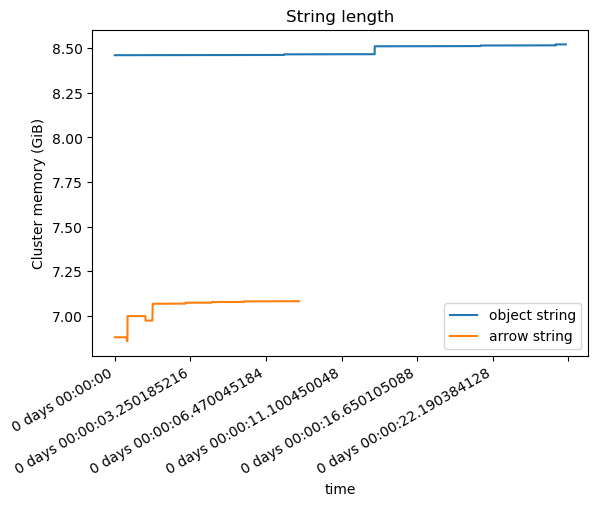

In [51]:
ms5.plot(align=True, title="String length")

In [52]:
client.restart()  # Release futures and clear up memory on the cluster

2023-03-29 13:25:48,218 - distributed.nanny - WARNING - Restarting worker
2023-03-29 13:25:48,263 - distributed.nanny - WARNING - Restarting worker
2023-03-29 13:25:48,264 - distributed.nanny - WARNING - Restarting worker
2023-03-29 13:25:48,264 - distributed.nanny - WARNING - Restarting worker


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56988,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: 17 minutes ago,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:57472,Total threads: 3
Dashboard: http://127.0.0.1:57475/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:56991,


In [53]:
client.close()

In [54]:
cluster.close()